# Reto 2

## Miguel Ortiz y Andrea Castiella


In [1]:
import numpy  as np
import pandas as pd
import OurUtils as our
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import PolynomialFeatures

In [2]:
FullSet_0 = pd.read_csv('./Reto2-Datasets/1000_cero.csv', header=None)
FullSet_3 = pd.read_csv('./Reto2-Datasets/1000_tres.csv', header=None)
FullSet_6 = pd.read_csv('./Reto2-Datasets/1000_seis.csv', header=None)
FullSet_9 = pd.read_csv('./Reto2-Datasets/1000_nueve.csv', header=None)


# Scale image to range [0,1]
FullSet_0 = FullSet_0 / 255.0
FullSet_3 = FullSet_3 / 255.0
FullSet_6 = FullSet_6 / 255.0
FullSet_9 = FullSet_9 / 255.0

## Feature Engineering
- Feature multiplication
- Feature division

In [3]:
# Multiplies the value of two given characteristics
def feat_mult(features, feat_name='', feat1 = 'feat_2', feat2 = 'feat-5'):
    mult = features[feat1] * features[feat2]
    return pd.DataFrame({feat_name:mult})

# Divides the value of two given characteristics
def feat_div(features, feat_name='', feat1 = 'feat_2', feat2 = 'feat-4'):
    div = features[feat1] / (features[feat2] + 0.00001)
    return pd.DataFrame({feat_name:div})


## Feature extraction
Label for number 0: 0
Label for number 3: 3
Label for number 6: 6
Label for number 9: 9


## Features

To select the features for this exercise, we take into consideration the geometric characteristics of each number.
First, the image was divided into 4 parts(upper, right, left, lower) and then we calculate the area/sum of the pixels in these parts. Then, we try to granulate more the zones that we selected before, and calculate the sum/area of a quarter of the image.

- feat_1: it represents the percentage of pixels superior to a certain threshold in the **left** side of the image. 
- feat_2: it represents the percentage of pixels superior to a certain threshold in the **lower** side of the image.
- feat_3: it represents the percentage of pixels superior to a certain threshold in the **right** side of the image.
- feat_4: it represents the percentage of pixels superior to a certain threshold in the **upper** side of the image.
- feat_5: it represents the percentage of pixels superior to a certain threshold in the **lower-right** side of the image.
- feat_6: Max value of the column sum of the entire image.
- feat_7: **width distance** of the number in the lower side of the image.
- feat_8: **height distance** of the number in the lower side of the image.
- feat_9: Ratio between the maximum width in the superior and lower part of the image.
- feat_10: it represents the division between the **upper and lower triangular matrix** of the image. It takes into consideration the percentage of pixels superior to a certain threshold.
- feat_11: Similar to feature 10 but making the division with the **squared values** of the upper and lower matrix.

In [4]:
from sklearn.preprocessing import KernelCenterer
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.preprocessing import QuantileTransformer

FullSet = our.join_features_labels(FullSet_0, FullSet_3, FullSet_6, FullSet_9)
seed = 1234
theta = 0.5
X_full = our.feat_extraction( FullSet.drop('label', axis=1))
area = feat_mult(X_full, 'area', feat1='feat_7', feat2='feat_8')
X_full = pd.concat([X_full, area],axis=1)
mult_25 = feat_mult(X_full, 'mult_25', feat1='feat_2', feat2='feat_5')
X_full = pd.concat([X_full, mult_25],axis=1)
mult_13 = feat_mult(X_full, 'mult_13', feat1='feat_1', feat2='feat_3')
X_full = pd.concat([X_full, mult_13],axis=1)
mult_24 = feat_mult(X_full, 'mult_24', feat1='feat_2', feat2='feat_4')
X_full = pd.concat([X_full, mult_24],axis=1)
mult_13_24 = feat_mult(X_full, 'mult_13_24', feat1='mult_13', feat2='mult_24')
X_full = pd.concat([X_full, mult_13_24],axis=1)

div_24 = feat_div(X_full, 'div_24', feat1='feat_2', feat2='feat_4')
X_full = pd.concat([X_full, div_24],axis=1)
div_13 = feat_div(X_full, 'div_13', feat1='feat_1', feat2='feat_3')
X_full = pd.concat([X_full, div_13],axis=1)
div_13_24 = feat_div(X_full, 'div_13_24', feat1='div_13', feat2='div_24')
X_full = pd.concat([X_full, div_13_24],axis=1)

div_24_2 = feat_div(X_full, 'div_24_2', feat1='div_24', feat2='div_24')
X_full = pd.concat([X_full, div_24_2],axis=1)
mult_24_2 = feat_mult(X_full, 'mult_24_2', feat1='div_24', feat2='div_24')
X_full = pd.concat([X_full, mult_24_2],axis=1)

feat_10_11 = feat_div(X_full, 'feat_10_11', feat1='feat_10', feat2='feat_11')
X_full = pd.concat([X_full, feat_10_11], axis=1)

col_names = list(X_full.columns)
qt = QuantileTransformer(n_quantiles=10, random_state=0)
X_full = qt.fit_transform(X_full)
X_full = pd.DataFrame(X_full,columns = col_names)

Y_full = FullSet[['label']]


## Split dataset
Train split: 1600 samples (80%)

Validation split: 400 samples (20%)

In [5]:
valid_size = 0.1
splitter = StratifiedShuffleSplit(n_splits=1, test_size=valid_size, random_state=seed)
split_ix = splitter.split(X_full,Y_full)
for train_ix, test_ix in split_ix:
    X_train = X_full.loc[train_ix].reset_index(drop=True)
    Y_train = Y_full.loc[train_ix].reset_index(drop=True)
    X_test  = X_full.loc[test_ix].reset_index(drop=True)
    Y_test  = Y_full.loc[test_ix].reset_index(drop=True)

## Feature selection

In [6]:
# Selected features after analyzing different combinations
feats = ['div_24', 'feat_11']
scaler = MinMaxScaler() 
X = scaler.fit_transform(X_train[feats]) # feats
Y = Y_train.values.ravel() # Returns data as numpy array


In [7]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X_train[feats]) # feats
Y = Y_train.values.ravel() # Returns data as numpy array


## Classifiers

In this section we create different classifiers to test them and see which gives better results.
**LogisticRegression** gives the best results. 

In [8]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import Perceptron, SGDClassifier

# base_clf = SVC(kernel='rbf', degree=2, gamma=1, random_state = seed) #<- it can be any other one
# base_clf = SVC(kernel='poly', degree=1, gamma=1, random_state = seed) #<- it can be any other one
# base_clf = LinearSVC(penalty='l2', loss='squared_hinge', random_state=seed, dual=True, C=1, tol=0.0001, multi_class='ovr')
base_clf = SGDClassifier(loss='squared_hinge', penalty='l2', alpha=0.0001, l1_ratio=0.15,
                         fit_intercept=True, tol=0.001, shuffle=True, epsilon=0.1, random_state=seed, 
                         learning_rate='optimal', max_iter=100000, n_jobs=8) 

# Train OvO - SVM
OvO_clf = OneVsOneClassifier(base_clf)
OvO_clf.fit(X,Y)

# Train OvR - SVM
OvR_clf = OneVsRestClassifier(base_clf)
OvR_clf.fit(X,Y)

# Check
strlog = "OvO produces %d classifiers" %(len(OvO_clf.estimators_))
print(strlog)
strlog = "OvR produces %d classifiers" %(len(OvR_clf.estimators_))
print(strlog)


OvO produces 6 classifiers
OvR produces 4 classifiers


In [9]:
# logistic regression training
from sklearn.linear_model import LogisticRegression
recta_regresion = LogisticRegression(penalty='l2', tol=1e-5, solver='lbfgs', max_iter=5000, warm_start=True) 
recta_regresion.fit(X,Y)

LogisticRegression(max_iter=5000, tol=1e-05, warm_start=True)

In [10]:
# perceptron training
perc = Perceptron(penalty='l2', alpha=0.0001, max_iter=10000, tol=0.00001, shuffle=True, n_jobs=8, early_stopping=True, random_state=seed)
perc = OneVsOneClassifier(perc)
perc.fit(X,Y)
scr = perc.score(X,Y)
p = perc.predict(X)
print(scr)
print(p)

0.7477426636568849
[6. 9. 3. ... 9. 6. 3.]


In [11]:
# Feature engineering, selection and rescaling to [0,1]
X_pred = scaler.transform(X_test[feats]) # feats
Y_true = Y_test.values.ravel()

# predict

Y_pred_OvO = OvO_clf.predict(X_pred)
Y_pred_OvR = OvR_clf.predict(X_pred)
Y_logreg = recta_regresion.predict(X_pred)
Y_perc = perc.predict(X_pred)




## Confusion Matrix

To check the performance of our model, we use Confusion Matrix as metric. This give us a general idea of how good is the model and let us compare it with the multiple combinations of feature that we have available.

In [12]:
# Comparative between the different models
# Performance metrics

conf_mat_OvO = confusion_matrix(Y_true, Y_pred_OvO)
hits_OvO = np.trace(conf_mat_OvO)
conf_mat_OvR = confusion_matrix(Y_true, Y_pred_OvR)
hits_OvR = np.trace(conf_mat_OvR)
conf_mat_logreg = confusion_matrix(Y_true, Y_logreg)
hits_logreg = np.trace(conf_mat_logreg)
conf_mat_perc = confusion_matrix(Y_true, Y_perc)
hits_perc = np.trace(conf_mat_perc)


# Print out
print("\nOvO confusion matrix:\n")
print(conf_mat_OvO)
print("\n")
print( "OvO Hits  = %d"%(hits_OvO))
print( "OvO Fails = %d"%(Y_true.shape[0]-hits_OvO))
print("\nOvR confusion matrix:\n")
print(conf_mat_OvR)
print( "\n")
print( "OvR Hits  = %d"%(hits_OvR))
print( "OvR Fails = %d"%(Y_true.shape[0]-hits_OvR))
print("\nLogreg confusion matrix:\n")
print(conf_mat_logreg)
print( "\n")
print( "nLogreg Hits  = %d"%(hits_logreg))
print( "nLogreg Fails = %d"%(Y_true.shape[0]-hits_logreg))
print("\nPerc confusion matrix:\n")
print(conf_mat_perc)
print( "\n")
print( "Perc Hits  = %d"%(hits_perc))
print( "Perc Fails = %d"%(Y_true.shape[0]-hits_perc))


OvO confusion matrix:

[[79 13  4  2]
 [ 7 86  2  5]
 [ 7  1 88  0]
 [ 1 13  0 86]]


OvO Hits  = 339
OvO Fails = 55

OvR confusion matrix:

[[78 14  4  2]
 [ 7 86  2  5]
 [ 6  2 88  0]
 [ 1  9  0 90]]


OvR Hits  = 342
OvR Fails = 52

Logreg confusion matrix:

[[86  8  3  1]
 [ 6 85  3  6]
 [ 7  0 89  0]
 [ 1  7  0 92]]


nLogreg Hits  = 352
nLogreg Fails = 42

Perc confusion matrix:

[[43 25 28  2]
 [ 1 77 10 12]
 [ 2  0 94  0]
 [ 0  4  0 96]]


Perc Hits  = 310
Perc Fails = 84


Model with best results: LogisticRegression

## Competition data
Using the transform method we can use the same mean and variance as it is calculated
from our training data to transform our test data (using fit_transform). Thus, the
parameters learned by our model using the training data will help us to transform our test data.
Transform features using quantiles information.
Using the Quantile Transformer the features are transformed to follow a uniform or a normal distribution. Therefore, for a given feature, this transformation tends to spread out the most frequent values. It also reduces the impact of (marginal) outliers: this is therefore a robust preprocessing scheme.

In [13]:
# Load competition data
challenge_data = pd.read_csv('./reto2_X.csv', header=None)
challenge_data = challenge_data/255.0
# Feature extraction
challenge_features = our.feat_extraction(challenge_data)
area = feat_mult(challenge_features, 'area', feat1='feat_7', feat2='feat_8')
challenge_features = pd.concat([challenge_features, area],axis=1)
mult_25 = feat_mult(challenge_features, 'mult_25', feat1='feat_2', feat2='feat_5')
challenge_features = pd.concat([challenge_features, mult_25],axis=1)
mult_24 = feat_mult(challenge_features, 'mult_24', feat1='feat_2', feat2='feat_4')
challenge_features = pd.concat([challenge_features, mult_24],axis=1)
mult_13 = feat_mult(challenge_features, 'mult_13', feat1='feat_1', feat2='feat_3')
challenge_features = pd.concat([challenge_features, mult_13],axis=1)
mult_13_24 = feat_mult(challenge_features, 'mult_13_24', feat1='mult_13', feat2='mult_24')
challenge_features = pd.concat([challenge_features, mult_13_24],axis=1)

div_24 = feat_div(challenge_features, 'div_24', feat1='feat_2', feat2='feat_4')
challenge_features = pd.concat([challenge_features, div_24],axis=1)
div_13 = feat_div(challenge_features, 'div_13', feat1='feat_1', feat2='feat_3')
challenge_features = pd.concat([challenge_features, div_13],axis=1)
div_13_24 = feat_div(challenge_features, 'div_13_24', feat1='div_13', feat2='div_24')
challenge_features = pd.concat([challenge_features, div_13_24],axis=1)
div_24_2 = feat_div(challenge_features, 'div_24_2', feat1='div_24', feat2='div_24')
challenge_features = pd.concat([challenge_features, div_24_2],axis=1)

mult_24_2 = feat_mult(challenge_features, 'mult_24_2', feat1='div_24', feat2='div_24')
challenge_features = pd.concat([challenge_features, mult_24_2],axis=1)

feat_10_11 = feat_div(challenge_features, 'feat_10_11', feat1='feat_10', feat2='feat_11')
challenge_features = pd.concat([challenge_features, feat_10_11], axis=1)

challenge_features = qt.fit_transform(challenge_features)
challenge_features = pd.DataFrame(challenge_features,columns = col_names)

challenge_features = scaler.transform(challenge_features[feats]) # feats
# Inference
Y_chal_OvO = OvO_clf.predict(challenge_features)
Y_chal_OvR = OvR_clf.predict(challenge_features)
Y_chal_logreg = recta_regresion.predict(challenge_features)
Y_chal_perc = perc.predict(challenge_features)

## Save results

In [14]:
#np.savetxt('Reto2_OvO_Ypred.csv', Y_chal_OvO, fmt='%i', delimiter=',')
np.savetxt('Reto2_Ypred.csv', Y_chal_logreg, fmt='%i', delimiter=',')

## Image Visualizer

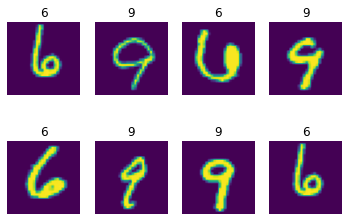

In [15]:
# Challenge images representation
from matplotlib import pyplot as plt
from numpy.random import default_rng
numb_img = 8
rng = default_rng()

chall_input = pd.read_csv('./reto2_X.csv', header=None)
numbers = rng.choice(chall_input.shape[0], size=numb_img, replace=False)

chall_input = chall_input / 255.0
chall_input = chall_input.values.reshape([chall_input.shape[0],28,28])

chall_results = pd.read_csv('./Reto2_Ypred.csv', header=None)
chall_results = chall_results.values

images = np.zeros((numb_img,28,28))
img_labels = np.zeros((numb_img,))
for i in range(numb_img):
    images[i] = chall_input[numbers[i],:,:]
    img_labels[i] = chall_results[numbers[i]]

f, axarr = plt.subplots(2,4)
x, y = 0, 0
for i in range(images.shape[0]):

    img_y = img_labels[i]
    axarr[x,y].imshow(images[i])
    axarr[x,y].axis('off')
    axarr[x,y].title.set_text(str(int(img_y)))
    y = y + 1
    if y == axarr.shape[1]:
        y = 0
        x = x + 1
        
plt.imshow(images[0])

[[86  8  3  1]
 [ 6 85  3  6]
 [ 7  0 89  0]
 [ 1  7  0 92]]


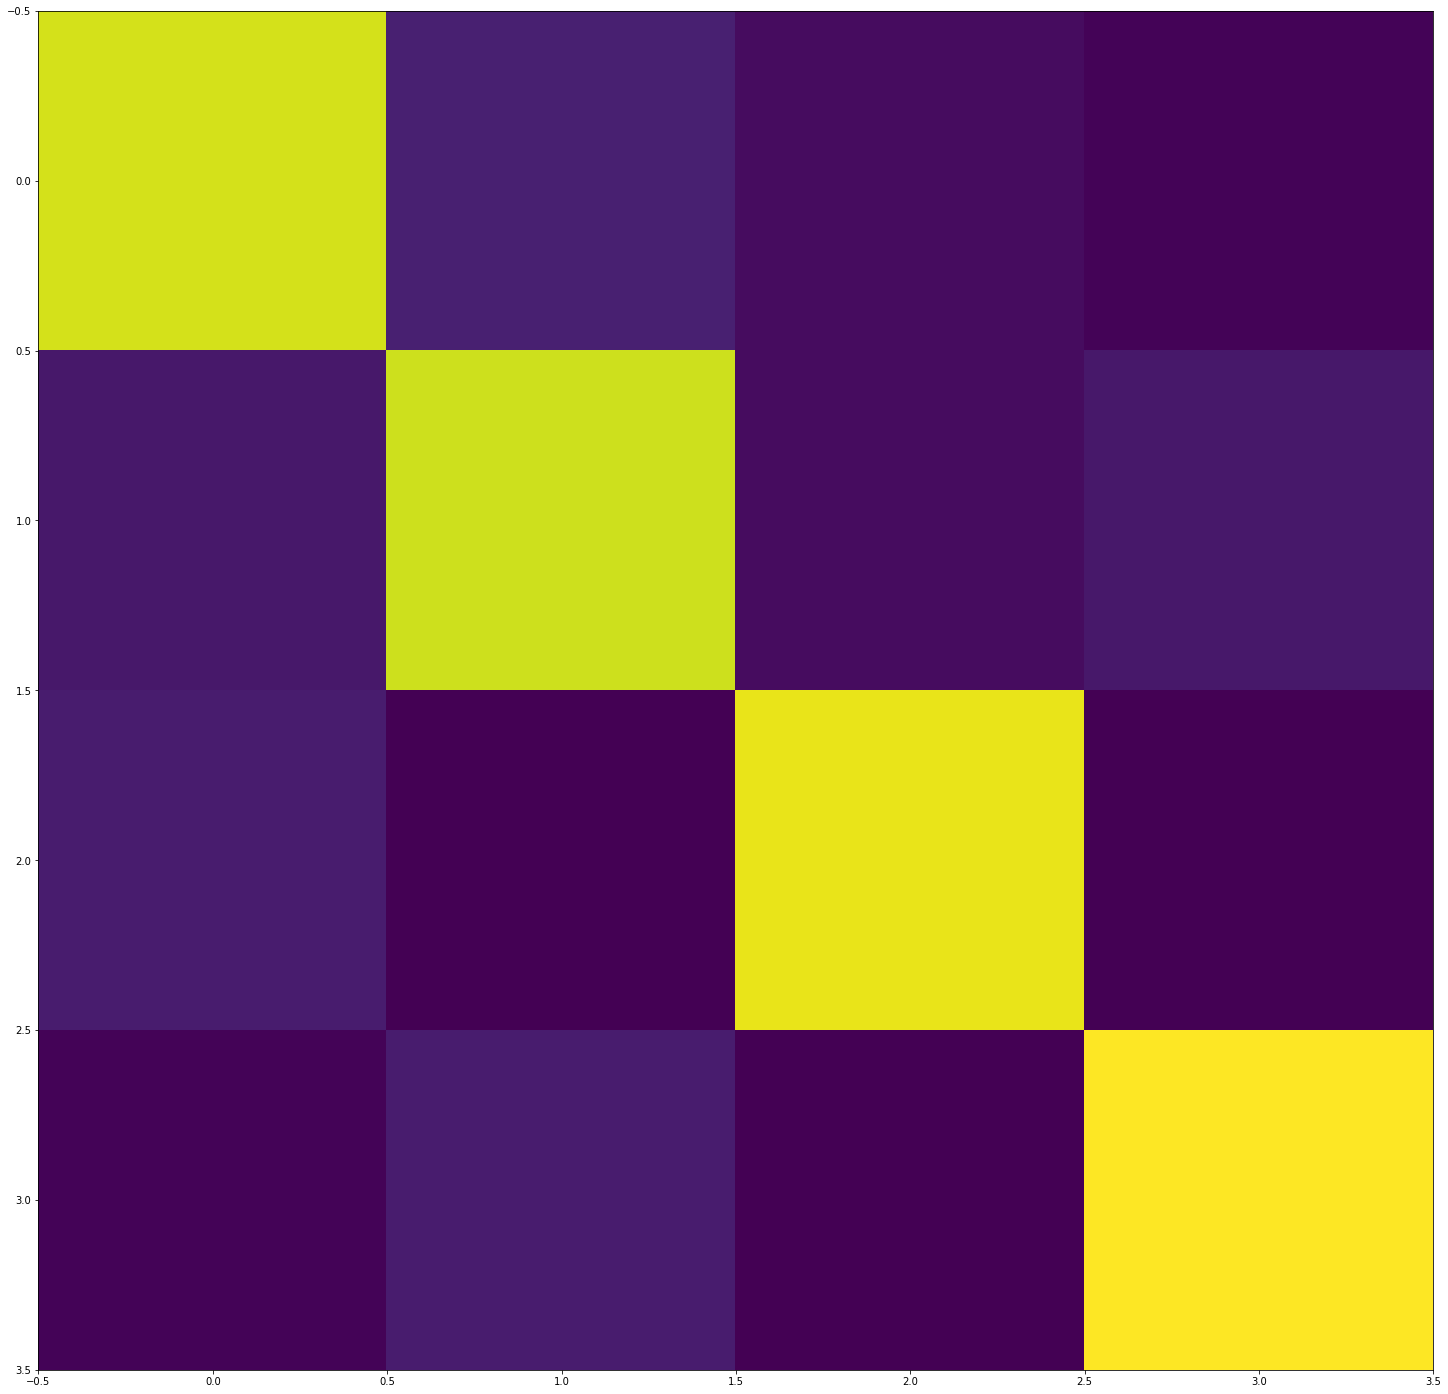

In [16]:
print(conf_mat_logreg)
plt.figure(figsize=(25,25))
plt.imshow(conf_mat_logreg, aspect='auto')